DATASET - drebin-215-dataset-5560malware-9476-benign.csv

In [1]:
import pandas as pd
import numpy as np

# Step 1: Load dataset
df = pd.read_csv("drebin-215-dataset-5560malware-9476-benign.csv", low_memory=False)

# Step 2: Check raw values in 'class' column BEFORE replacing '?'
print("Unique values in 'class' before cleanup:")
print(df['class'].unique())

# Step 3: Separate target column early before replacing '?'
y_raw = df['class']  # keep original
X_raw = df.drop('class', axis=1)

# Step 4: Replace '?' with np.nan only in features
X = X_raw.replace('?', np.nan)

# Step 5: Convert features to numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Step 6: Drop rows with missing feature values
X['class'] = y_raw  # temporarily add back for joint filtering
X.dropna(subset=X.columns.difference(['class']), inplace=True)

# Step 7: Extract cleaned target and features
y = X['class']
X = X.drop('class', axis=1)

# Step 8: Show cleaned target
print("\nCleaned target variable (y) unique values:")
print(y.unique())

# Step 9: Drop rows where y is NaN
mask = y.notna()
X = X[mask]
y = y[mask]

# Step 10: Encode labels
y = y.map({'S': 1, 'B': 0})

# Final sanity check
print("\nFinal target distribution:")
print(y.value_counts())


Unique values in 'class' before cleanup:
['S' 'B']

Cleaned target variable (y) unique values:
['S' 'B']

Final target distribution:
class
0    9476
1    5555
Name: count, dtype: int64


In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report

# 1. Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
print("\nShape after scaling:", X_scaled.shape)

# 2. Train-validation-test split (80-10-10)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 3. PCA for dimensionality reduction
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)
print("\nShape after PCA transformation:", X_train_pca.shape)

# 4. Train LightGBM
model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train_pca, y_train)

# 5. Predict and evaluate
y_pred = model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))



Shape after scaling: (15031, 215)

Shape after PCA transformation: (12024, 102)
[LightGBM] [Info] Number of positive: 4434, number of negative: 7590
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26010
[LightGBM] [Info] Number of data points in the train set: 12024, number of used features: 102
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.368762 -> initscore=-0.537529
[LightGBM] [Info] Start training from score -0.537529

Accuracy: 0.9900
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       929
           1       0.99      0.98      0.99       575

    accuracy                           0.99      1504
   macro avg       0.99      0.99      0.99      1504
weighted avg       0.99      0.99      0.99      1504



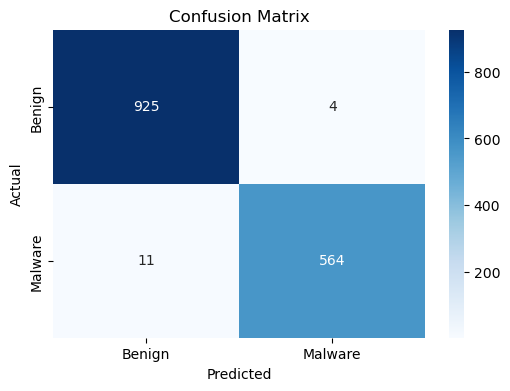

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malware'], yticklabels=['Benign', 'Malware'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


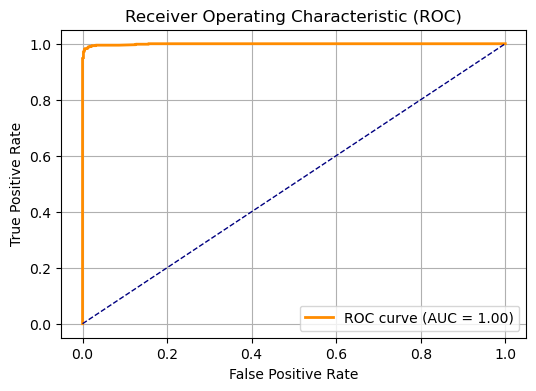

In [4]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for positive class (malware = 1)
y_pred_proba = model.predict_proba(X_test_pca)[:, 1]

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


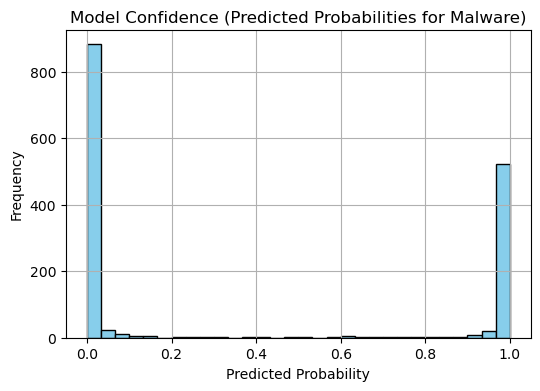

In [5]:
# Plot histogram of predicted probabilities
plt.figure(figsize=(6, 4))
plt.hist(y_pred_proba, bins=30, color='skyblue', edgecolor='black')
plt.title("Model Confidence (Predicted Probabilities for Malware)")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


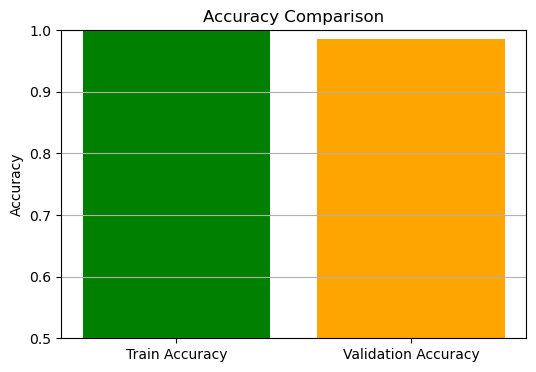

Train Accuracy: 0.9994
Validation Accuracy: 0.9854


In [6]:
# Predictions for validation set
y_val_pred = model.predict(X_val_pca)

# Accuracy comparison
train_acc = accuracy_score(y_train, model.predict(X_train_pca))
val_acc = accuracy_score(y_val, y_val_pred)

# Bar Plot
plt.figure(figsize=(6, 4))
plt.bar(['Train Accuracy', 'Validation Accuracy'], [train_acc, val_acc], color=['green', 'orange'])
plt.ylim(0.5, 1.0)
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.grid(axis='y')
plt.show()

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
